**Atmospheric Compensation With Emphirical Line Method (ELM)**  
**Author: Ramesh Bhatta, CIS, RIT**  
**Data: Dr. Emmet Ientilucci**

**1. Code To Produce a Compensated HSI cube.**

In [17]:
## Read the Hysperspectral Data Cube

import spectral.io.envi as envi
import spectral
import numpy as np
import cv2
import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt

## HSI Data Cube

HSI_cube = envi.open('2017-08-01_14-28-56_000011__061158-066258_radiance_fwd_proj_subset.hdr', "2017-08-01_14-28-56_000011__061158-066258_radiance_fwd_proj_subset.bin")

print("Data Information:\n")
print(HSI_cube.read_bands)

## Reading the Ground Spectral of dark, while , red and blue panel from given excel file as padas dataframe
header = spectral.envi.read_envi_header('2017-08-01_14-28-56_000011__061158-066258_radiance_fwd_proj_subset.hdr')
spectral_df = pd.read_excel('Spectra_8_01_2017.xlsx')
spectral_df.head()

Data Information:

<bound method BilFile.read_bands of 	Data Source:   './2017-08-01_14-28-56_000011__061158-066258_radiance_fwd_proj_subset.bin'
	# Rows:            234
	# Samples:         340
	# Bands:           372
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16>


,WL_nm,Dark,White,WL2_um,RED,BLUE
0,334.3,6.69,45.07,0.350,0.0444,0.032250
1,335.8,6.64,44.29,0.351,0.0444,0.031119
2,337.3,6.79,45.71,0.352,0.0444,0.031001
3,338.8,6.94,46.27,0.353,0.0448,0.031717
4,340.3,6.84,48.53,0.354,0.0456,0.032072


In [18]:


# lines, pixels, num_of_bands = HSI_cube.shape
# wave_lengths = HSI_cube.bands.centers

# map = []
# for i in range(1, len(wave_lengths)):
#     map.append([i, wave_lengths[i]])

# ## Using the map find the index of closest wavelength to the given wavelength

# def find_nearest_wavelength(wavelength):
#     return min(map, key=lambda x: abs(x[1] - wavelength))

# green = find_nearest_wavelength(550)
# red = find_nearest_wavelength(660)
# blue = find_nearest_wavelength(450)

# ## Extract a RGB image from HSI_cube using the above indices

# rgb_image = HSI_cube[:,:, [red[0], green[0], blue[0]]]
# spectral.imshow(rgb_image)
# plt.title('Spectral RGB Subimage')
# plt.show()

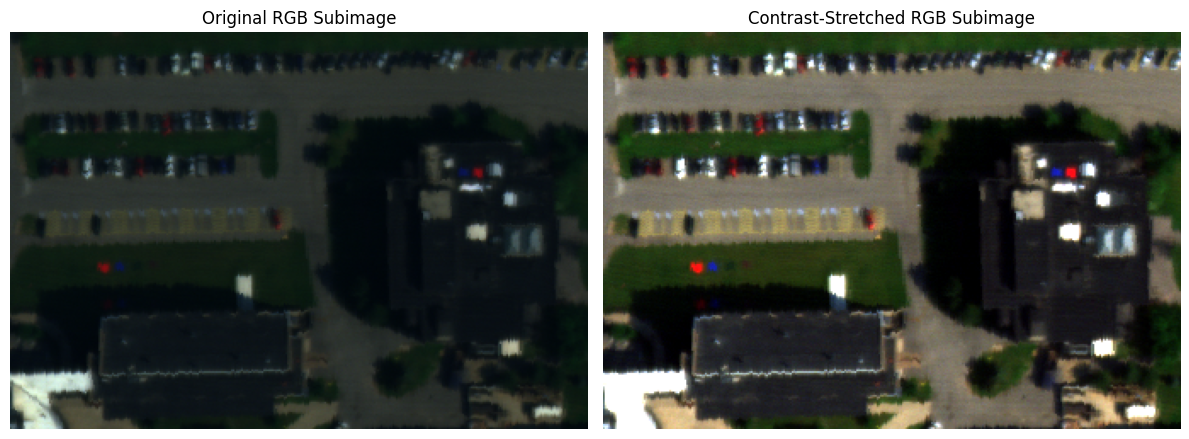

In [19]:
## Mapping Band Indices and Wavelengths

lines, pixels, num_of_bands = HSI_cube.shape
wave_lengths = HSI_cube.bands.centers

# Map band indices to wavelengths
band_map = [[i, wave_lengths[i]] for i in range(len(wave_lengths))]

# Function to find the nearest wavelength
def find_nearest_wavelength(wavelength):
    return min(band_map, key=lambda x: abs(x[1] - wavelength))

# Find bands for green, red, and blue wavelengths
green = find_nearest_wavelength(550)
red = find_nearest_wavelength(660)
blue = find_nearest_wavelength(450)

# Extract the RGB image from HSI_cube
rgb_image = HSI_cube[:, :, [red[0], green[0], blue[0]]]

# Normalize the RGB image to [0, 1] for proper visualization
rgb_image_normalized = rgb_image.astype(np.float32)
rgb_image_normalized -= rgb_image_normalized.min()
rgb_image_normalized /= rgb_image_normalized.max()

# Perform contrast stretching using percentile stretching
p_low, p_high = 2, 98  # Percentiles for stretching
stretched_image = np.zeros_like(rgb_image_normalized)

for i in range(3):  # Process each channel independently
    channel = rgb_image_normalized[:, :, i]
    p_min, p_max = np.percentile(channel, (p_low, p_high))
    stretched_image[:, :, i] = exposure.rescale_intensity(
        channel, in_range=(p_min, p_max), out_range=(0, 1)
    )

# Plot the original and contrast-stretched
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(rgb_image_normalized)
axes[0].set_title('Original RGB Subimage')
axes[0].axis('off')

axes[1].imshow(stretched_image)
axes[1].set_title('Contrast-Stretched RGB Subimage')
axes[1].axis('off')

plt.tight_layout()
plt.show()

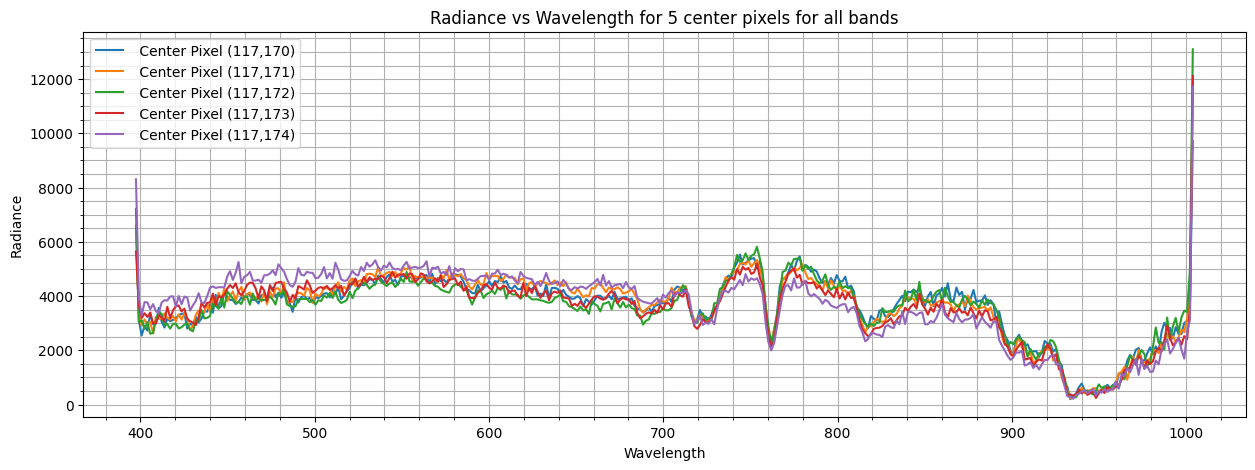

In [23]:
## plot for 5 center pixels profiles

plt.figure(figsize=(15,5))
for i in range(5):
    plt.plot(wave_lengths, HSI_cube.read_pixel(lines//2, pixels//2 + i), label = ' Center Pixel ('+str(lines//2)+','+str( pixels//2 + i)+')')
plt.xlabel('Wavelength')
plt.ylabel('Radiance')
plt.legend()
plt.grid(which='both')
plt.minorticks_on()
plt.title('Radiance vs Wavelength for 5 center pixels for all bands')
plt.show()

In [21]:
## Determining the cal-panel mean spectra
"""
This is an important part. The code will be used to generate the mean spectra of white and dark calibration panel to be used for atmospheric compentation.
Basically when we run this function, the OpenCv window pops up and we can select pixels which we think are cal-panels. Then finally it returns the mean spectrum 
of all those pixels. We have done it for white and panel in next block of code. For each panel the code is supposed to be called or 'accessed' individually.

Summary: Hover over RGB image and find the pixel location of Dark and White Panel to get the radiance values from the HSI_cube
"""

def extract_panel_spectra():
    bgr_image = cv2.cvtColor(np.uint8(rgb_image/rgb_image.max()*255), cv2.COLOR_RGB2BGR)

    # Display the image using OpenCV
    cv2.imshow('RGB Image', bgr_image)

    # Define a callback function for mouse clicks

    panel_location = []
    def on_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            print(f"Pixel location: ({x}, {y})")
            panel_location.append((x, y))       
    cv2.setMouseCallback('RGB Image', on_click)

    # Wait for a key press to exit
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    panel_spectra = []
    for pixels in panel_location:
        intermediate = HSI_cube.read_pixel(pixels[1], pixels[0])
    panel_spectra.append(intermediate)
    mean = np.mean(panel_spectra, axis=0)
    return mean,  panel_location

In [22]:
## Extract the mean radiance spectra of white panel using pixel location from above code--Use 'Esc' to escape out of Cv2 window

white_panel_spectra, white_loc = extract_panel_spectra() ## This will give mean_white_panel spectrum
dark_panel_spectra, dark_loc = extract_panel_spectra()   ## This will give dark_white_panel spectrum

Pixel location: (268, 92)
Pixel location: (272, 92)
Pixel location: (275, 92)
Pixel location: (268, 91)
Pixel location: (266, 92)
Pixel location: (271, 92)
Pixel location: (271, 92)
Pixel location: (269, 92)
Pixel location: (273, 92)
Pixel location: (270, 103)
Pixel location: (273, 103)
Pixel location: (271, 109)
Pixel location: (270, 103)
Pixel location: (270, 109)
Pixel location: (274, 107)
Pixel location: (270, 107)
Pixel location: (268, 108)
Pixel location: (268, 107)


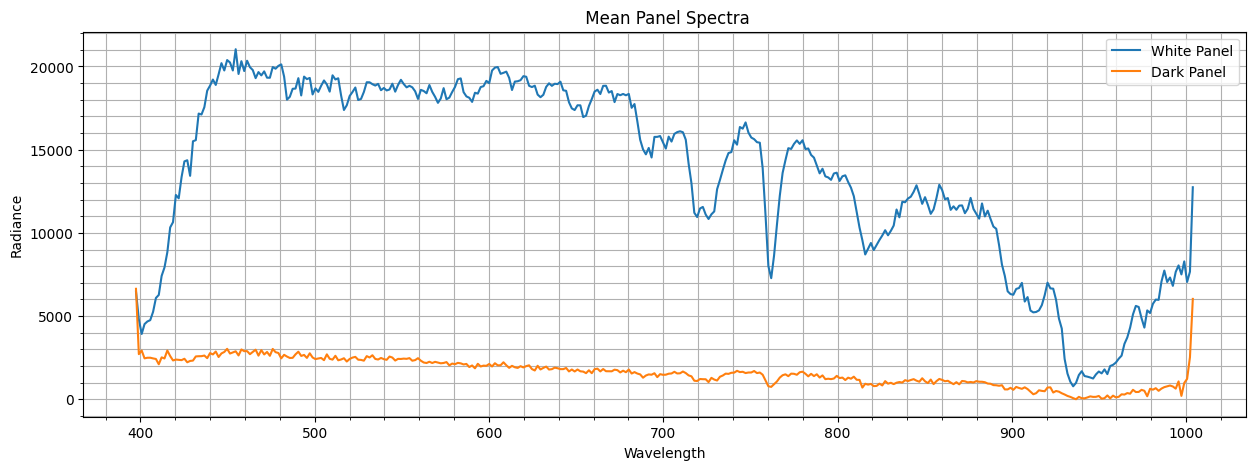

In [9]:
## Plot of Mean Panel Spectra

plt.figure(figsize=(15,5))
plt.plot(wave_lengths, white_panel_spectra, label='White Panel')
plt.plot(wave_lengths, dark_panel_spectra, label='Dark Panel')
plt.legend()
plt.grid(which='both')
plt.minorticks_on()
plt.title(' Mean Panel Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Radiance')
plt.show()

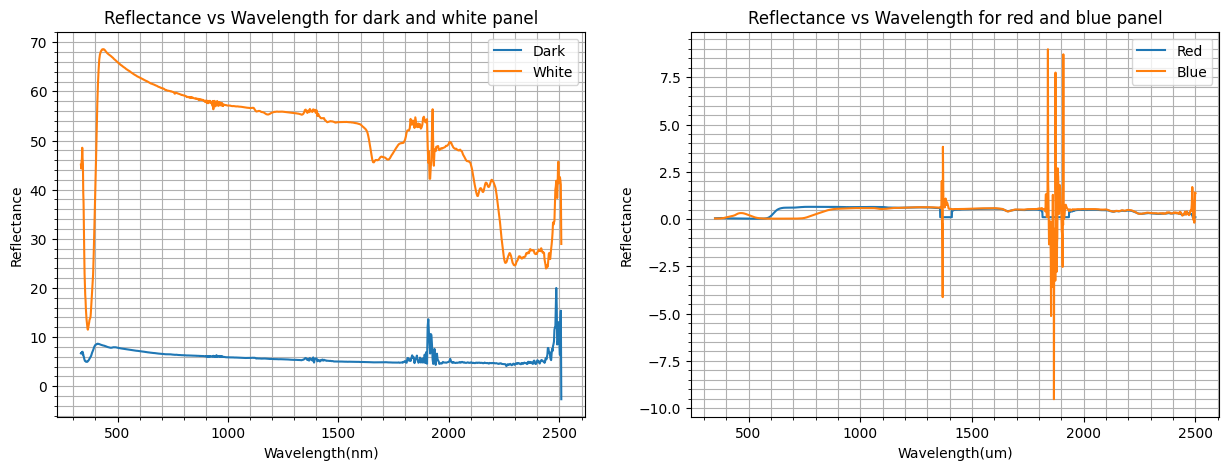

In [24]:
## Plotting the Ground Spectral of dark, while , red and blue panel 

plt.figure(figsize=(15,5))

## subplot 1:
plt.subplot(1,2,1)
plt.plot(spectral_df['WL_nm'], spectral_df['Dark'], label = 'Dark')
plt.plot(spectral_df['WL_nm'], spectral_df['White'], label = 'White')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflectance')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Reflectance vs Wavelength for dark and white panel')

## subplot 2:
plt.subplot(1,2,2)
plt.plot(spectral_df['WL2_um']*1e3, spectral_df['RED'], label = 'Red')
plt.plot(spectral_df['WL2_um']*1e3, spectral_df['BLUE'], label = 'Blue')
plt.xlabel('Wavelength(um)')
plt.ylabel('Reflectance')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Reflectance vs Wavelength for red and blue panel')
plt.show()


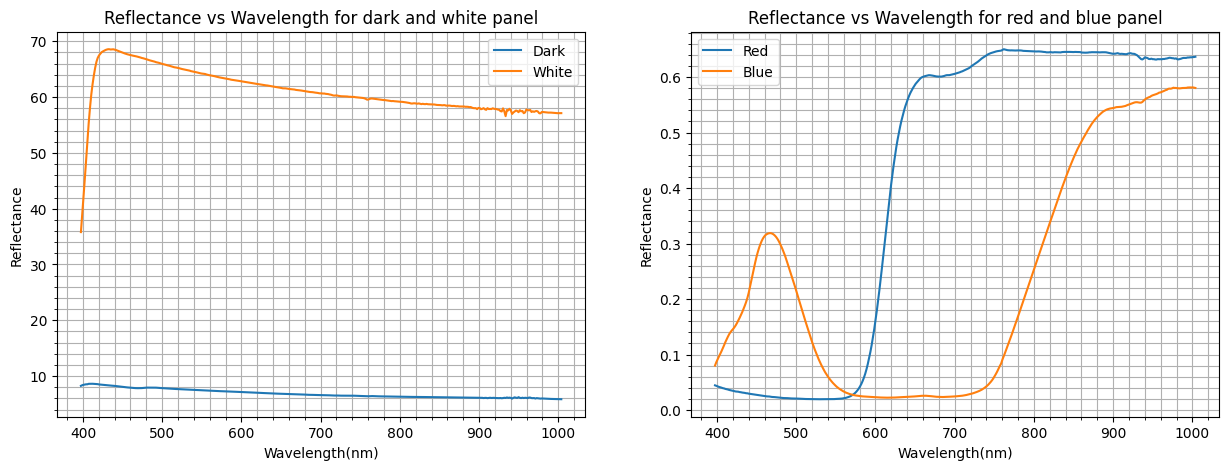

In [25]:
## Interploation of the Ground Spectral of dark, while , red and blue panel to the HSI cube wave lengths and make new dataframe with
## new wave lengths and reflectance values

dark_ref = np.interp(wave_lengths, spectral_df['WL_nm'], spectral_df['Dark'])
white_ref = np.interp(wave_lengths, spectral_df['WL_nm'], spectral_df['White'])
red_ref = np.interp(wave_lengths, spectral_df['WL2_um']*1e3, spectral_df['RED'])
blue_ref = np.interp(wave_lengths, spectral_df['WL2_um']*1e3, spectral_df['BLUE'])

new_df = pd.DataFrame({'WL_nm':wave_lengths, 'Dark':dark_ref, 'White':white_ref, 'RED':red_ref, 'BLUE':blue_ref})

## Plotting the Interploated Ground Spectral of dark, while , red and blue panel

plt.figure(figsize=(15,5))

## subplot 1:

plt.subplot(1,2,1)
plt.plot(new_df['WL_nm'], new_df['Dark'], label = 'Dark')
plt.plot(new_df['WL_nm'], new_df['White'], label = 'White')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflectance')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Reflectance vs Wavelength for dark and white panel')

## subplot 2:

plt.subplot(1,2,2)
plt.plot(new_df['WL_nm'], new_df['RED'], label = 'Red')
plt.plot(new_df['WL_nm'], new_df['BLUE'], label = 'Blue')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflectance')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Reflectance vs Wavelength for red and blue panel')
plt.show()


**2. Calculating and Plotting Gain and Bais**

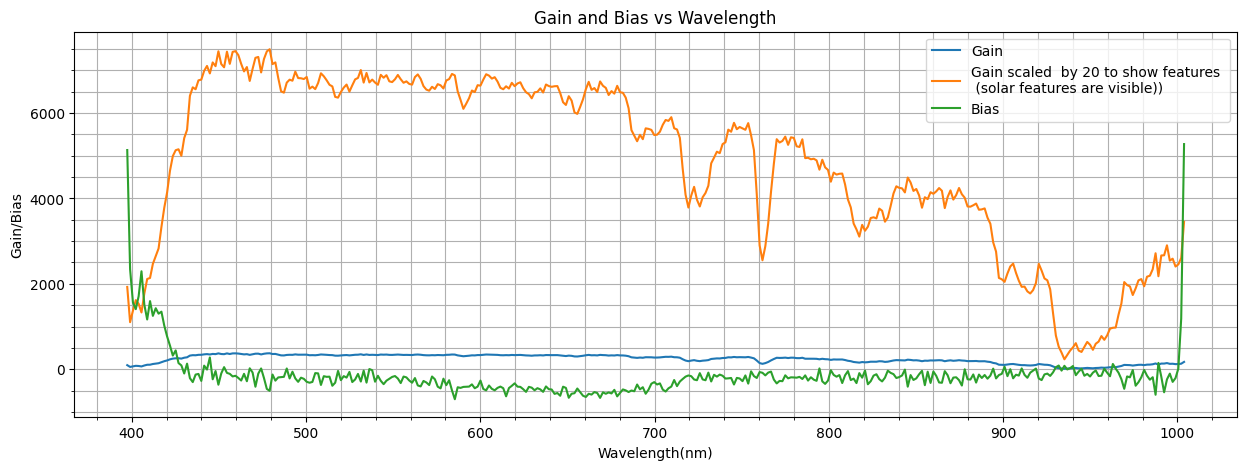

In [26]:
## Setting Up the ELM regression model

gain = (white_panel_spectra - dark_panel_spectra)/(white_ref - dark_ref)
bias = (dark_panel_spectra*white_ref - white_panel_spectra*dark_ref)/(white_ref - dark_ref)

## Plotting the gain and bias

plt.figure(figsize=(15,5))
plt.plot(wave_lengths, gain, label = 'Gain')
plt.plot(wave_lengths, gain*20, label = 'Gain scaled  by 20 to show features \n (solar features are visible))')
plt.plot(wave_lengths, bias, label = 'Bias')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Gain/Bias')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Gain and Bias vs Wavelength')
plt.show()

**Explanation**  
The gain is due to the direct term in the ELM equation (see the equation in the `README` section), and it shows the features similar to solar spectrum features as expected. It also shows that the atmosphere is quite homogenous during the data acquisition. However, there is quite variation in the bias term with higher bias value at shorter wavelengths and lower at longer wavelengths which is expected since the bias term represents the path radiance which is (mostly) due to the scattered light in the atmosphere and as per Rayleigh criterion the scattering is higher at shorter wavelengths.

In [27]:
## Applying the ELM model to the HSI cube and determining the reflectance for each pixel on the surface

def elm_model(gain, bias):
    reflectance = np.zeros((lines, pixels, num_of_bands))
    for i in range(lines):
        for j in range(pixels):
            reflectance[i, j, :] = (HSI_cube.read_pixel(i, j) - bias)/gain
    return reflectance

reflectance = elm_model(gain, bias)

**3. Cross Check with the  Calibration Panel**

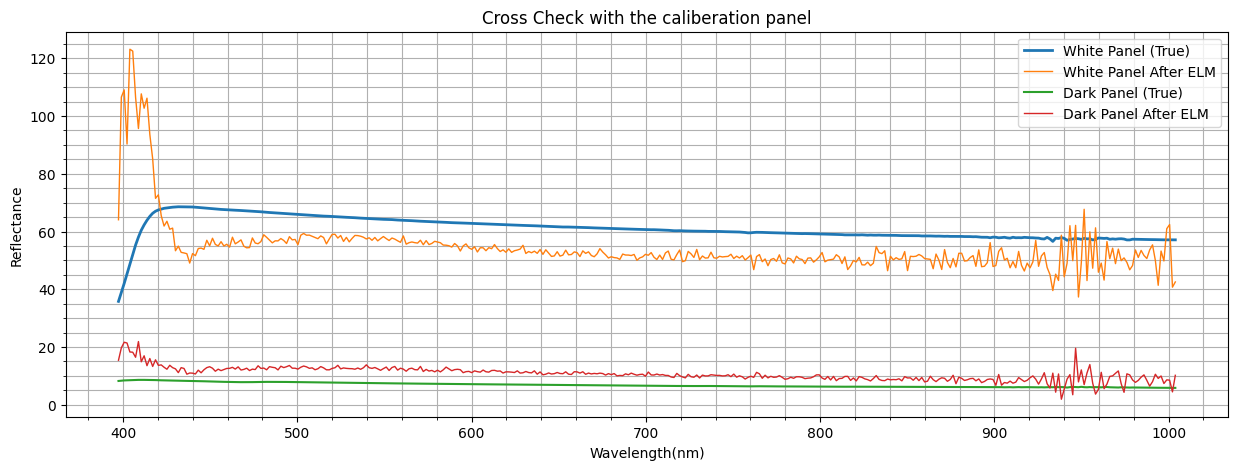

In [29]:
## Plot for caliberation panel before and after applying ELM model

plt.figure(figsize=(15,5))
plt.plot(wave_lengths, new_df['White'], label = 'White Panel (True)', linewidth=2)
plt.plot(wave_lengths, reflectance[100, 294, :], label = 'White Panel After ELM', linewidth=1)
plt.plot(wave_lengths, new_df['Dark'], label = 'Dark Panel (True)')
plt.plot(wave_lengths, reflectance[100, 300, :], label = 'Dark Panel After ELM',  linewidth=1)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflectance')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Cross Check with the caliberation panel')
plt.show()

Looking at the plot for cross checking with the calibration panel we can see that there is almost exact match for both true panel reflectances and panel reflectances after compensation which is obviously expected since we used those panels to caliberate the whole HSI cube. However we can see some noise in the caliberated data.

**4. Cross check with Blue and Red color panels**


In [ ]:
mred, red_pixel = extract_panel_spectra()
mblue, blue_pixel = extract_panel_spectra()

Pixel location: (275, 83)
Pixel location: (55, 139)
Pixel location: (55, 140)
Pixel location: (275, 83)
Pixel location: (268, 84)
Pixel location: (62, 139)


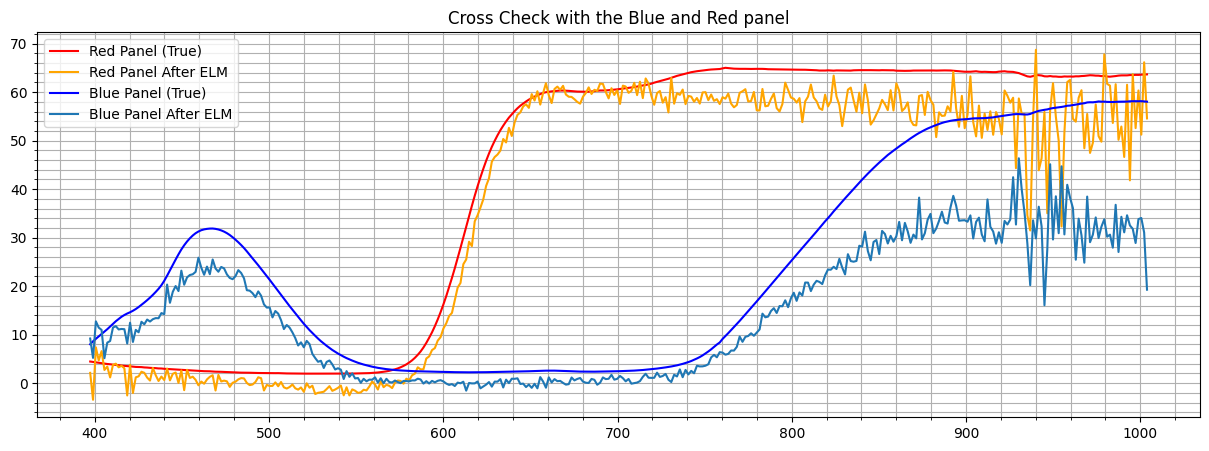

In [ ]:
## Plotting For Red and Blue Panel before and after applying ELM model

plt.figure(figsize=(15,5))
plt.plot(wave_lengths, new_df['RED'] * 100, label = 'Red Panel (True)', color='red')
plt.plot(wave_lengths, reflectance[red_pixel[0][1], red_pixel[0][0], :], label = 'Red Panel After ELM', color='orange')
plt.plot(wave_lengths, new_df['BLUE'] * 100, label = 'Blue Panel (True)', color='blue')
plt.plot(wave_lengths, reflectance[blue_pixel[0][1], blue_pixel[0][0], :], label = 'Blue Panel After ELM')
plt.legend()
plt.grid(which='both')
plt.minorticks_on()
plt.title('Cross Check with the Blue and Red panel')
plt.show()

LOOKS GREAT!!!

**5. Vegetation Reflectance Plot**

Pixel location: (237, 198)


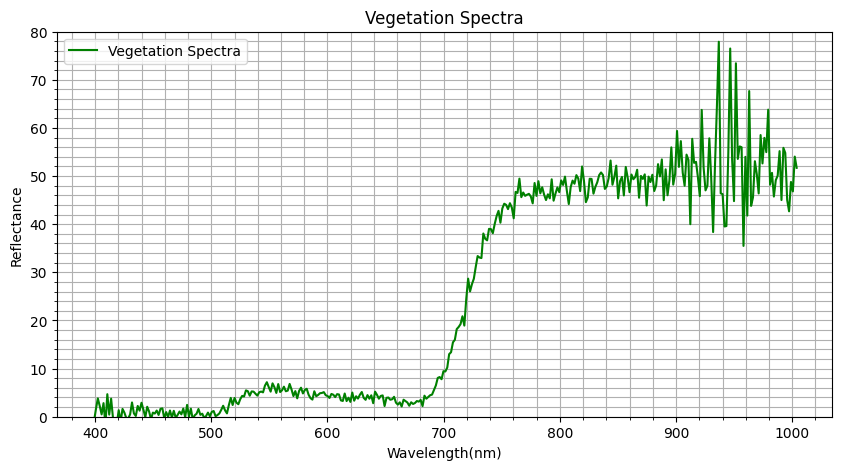

In [ ]:
veg_spectra, veg_pixel = extract_panel_spectra()

## Plotting the Spectra of Vegetation

plt.figure(figsize=(10,5))
plt.plot(wave_lengths, reflectance[veg_pixel[0][1], veg_pixel[0][0], :], label = 'Vegetation Spectra', color='green') 
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflectance')
plt.grid(which='both')
plt.ylim(0, 80)
plt.minorticks_on()
plt.legend()
plt.title('Vegetation Spectra')
plt.show()

**Looks Good: Absorption in blue and red and reflection in green region and the red edge.**

**6. Alternative: If We dont have dark panel in the scene then: I can set L1 = 0 and rho_1 = 0 or dark_radiance = 0 and dark reflectance = 0.**  
So the new regression would be:

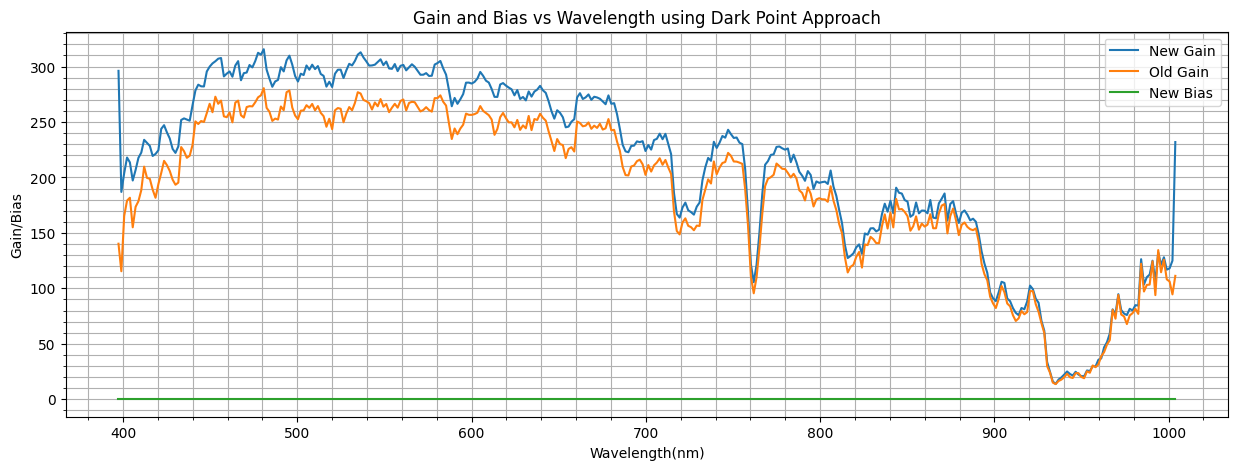

In [ ]:
new_gain = (white_panel_spectra)/(white_ref)

## set new bias to zero for all bands

new_bias = np.zeros(len(wave_lengths))
new_reflectance = elm_model(new_gain, new_bias)

## Plot of new gain and bias

plt.figure(figsize=(15,5))
plt.plot(wave_lengths, new_gain, label = 'New Gain')
plt.plot(wave_lengths, gain, label = 'Old Gain')
plt.plot(wave_lengths, new_bias, label = 'New Bias')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Gain/Bias')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.title('Gain and Bias vs Wavelength using Dark Point Approach')
plt.show()


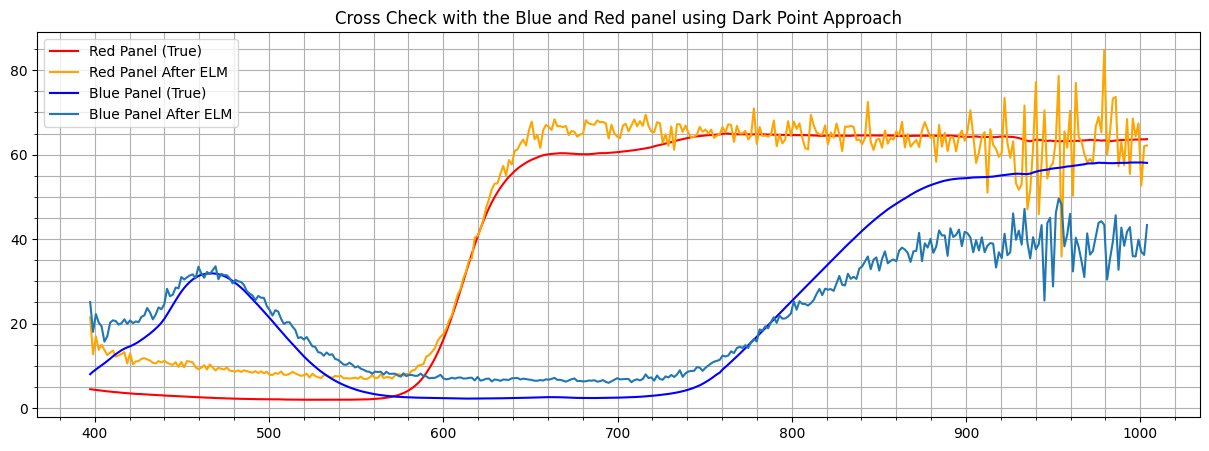

In [ ]:
## Check the result for blue and red panels

plt.figure(figsize=(15,5))
plt.plot(wave_lengths, new_df['RED'] * 100, label = 'Red Panel (True)', color='red')
plt.plot(wave_lengths, new_reflectance[red_pixel[0][1], red_pixel[0][0], :], label = 'Red Panel After ELM', color='orange')
plt.plot(wave_lengths, new_df['BLUE'] * 100, label = 'Blue Panel (True)', color='blue')
plt.plot(wave_lengths, new_reflectance[blue_pixel[0][1], blue_pixel[0][0], :], label = 'Blue Panel After ELM')
plt.legend()
plt.grid(which='both')
plt.minorticks_on()
plt.title('Cross Check with the Blue and Red panel using Dark Point Approach')
plt.show()

Even if we don’t have the dark panel in the scene for calibration the compensated data by using dark point selection for the dark panel looks good. As we can also see the gain plot without using dark point selection and with using dark point selection doesn’t vary much in figure 6. So, the shape of the spectra are almost same in both cases and only a little shift in positions due to bias term is visible

**7. Final Note:  Assumptions about caliberation Panels in the Scene.**

•	The calibration panels are diffused, Lambertian targets i.e., the BRDF is angle independent.  
•	The viewing range is the same for all the points in the scene.  
•	Direct and Diffuse illumination are space invariant (Constant illumination).  
•	Atmosphere is constant over the scene
